**Snapshots**: https://www.tng-project.org/data/downloads/TNG300-1/

In [1]:
import numpy as np 

import pickle

import pandas as pd


import multicam

from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt

In [3]:
trees_file = "../../data/processed/tng/TNG300-1_cut_trees.p"
tng_snapshot_dir = "../../data/processed/tng/TNG300-1/"  # everything is a host halo
present_snapfile = tng_snapshot_dir + "TNG300-1_HaloHistory_MBP_snap99.hdf5"

In [4]:
snaps = np.arange(0, 100, 1)

In [5]:
metadata = pd.read_csv("../../data/processed/tng/tng300-1-table.csv")
zs = metadata['Redshift'].values
scales = 1 / (1 + zs)

In [6]:
TNG_H = 0.6774

In [7]:
def _convert_tng_mass(gmass):
    # robust to 0 mass
    return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)

In [8]:
def _reverse_trees(trees):
    """Reverse each entry in trees so that order is from early to late times."""
    for tree in trees:
        for key in tree.keys():
            if key not in ["Number", "ChunkNumber", "TreeID"]:
                tree[key] = tree[key][::-1]
    return trees

In [9]:
def _read_trees(trees_file:str):
    """Read in the trees file and convert masses to log10(M/Msun)."""
    with open(trees_file, 'rb') as pickle_file:
        _trees = pickle.load(pickle_file)
        trees = _reverse_trees(_trees)
        for tree in trees:
            for k in tree.keys():
                if "Mass" in k or "_M_" in k: 
                    tree[k] = _convert_tng_mass(tree[k])
    return trees

## TNG explore file

In [32]:
# explore one tng file
import h5py
import numpy as np
one_file = tng_snapshot_dir + "TNG300-1_HaloHistory_MBP_snap99.hdf5" # everything is a host halo
f = h5py.File(one_file, 'r')

In [33]:
list(f.keys())

['Halos']

In [34]:
f['Halos'].keys()

<KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values', 'block1_items', 'block1_values', 'block2_items', 'block2_values']>

In [35]:
ds = f['Halos']['axis0']
ds[:].shape, ds[:]

((210,),
 array([b'HaloID', b'SubhaloID', b'SubhaloID_DMO', b'SubhaloID_LastDesc',
        b'Central', b'Main', b'Mvir_TNG', b'Rvir_TNG', b'pos_x', b'pos_y',
        b'pos_z', b'vel_x', b'vel_y', b'vel_z', b'delta_2cMpc',
        b'delta_5cMpc', b'delta_10cMpc', b'delta_20cMpc', b'delta_40cMpc',
        b'cvir_init', b'cvir_init_err', b'rho_s_init', b'rho_s_init_err',
        b'Bound_Nfrac', b'Bound_Mfrac', b'Bound_Nfrac_SUBFIND', b'Rvir',
        b'Mvir', b'R200c', b'M200c', b'R500c', b'M500c', b'R2500c',
        b'M2500c', b'Core_vel_x', b'Core_vel_y', b'Core_vel_z', b'Ngas',
        b'Nstars', b'Nbhs', b'Mgas_vir', b'Zgas_vir', b'SFR_vir', b'Y_vir',
        b'Tm_vir', b'K_vir', b'Mgas_200c', b'Zgas_200c', b'SFR_200c',
        b'Y_200c', b'Tm_200c', b'K_200c', b'Mgas_500c', b'Zgas_500c',
        b'SFR_500c', b'Y_500c', b'Tm_500c', b'K_500c', b'Mgas_2500c',
        b'Zgas_2500c', b'SFR_2500c', b'Y_2500c', b'Tm_2500c', b'K_2500c',
        b'Mgas_10pkpc', b'Zgas_10pkpc', b'SFR_10pkpc', 

In [36]:
ds = f['Halos']['axis1']
ds[:]

array([    0,     1,     2, ..., 13640, 13641, 13642])

In [37]:
ds = f['Halos']['block0_values']
ds[:].shape

(13643, 205)

In [38]:
ds = f['Halos']['block1_items']
ds[:]

array([b'HaloID', b'SubhaloID', b'SubhaloID_DMO', b'SubhaloID_LastDesc'],
      dtype='|S18')

In [39]:
ds = f['Halos']['block1_values']
ds[:].shape

(13643, 4)

In [40]:
ds = f['Halos']['block2_items']
ds[:]

array([b'EndState'], dtype='|S8')

In [41]:
ds = f['Halos']['block2_values']
ds[:].shape

(1,)

### Extract relevant quantities

In [42]:
data = {}

In [43]:
# from 'block1' we just neeed halo_id
names = ['halo_id', 'subhalo_id']
keys = [b'HaloID', b'SubhaloID']
for name, key in zip(names, keys):
    idx = np.where(f['Halos']['block1_items'][:] == key)[0].item()
    data[name] = f['Halos']['block1_values'][:,idx]

# halo_id = f['Halos']['block1_values'][:,0]
# mvir = f['Halos']['block0_values'][:,1]

In [44]:
# from 'block0' we need mvir
names = ['mvir', 'm200', 'rvir', 'r200', 'm500', 'r500']
keys = [b'Mvir', b'M200c', b'Rvir', b'R200c', b'M500c', b'R500c']
for name, key in zip(names, keys):
    idx = np.where(f['Halos']['block0_items'][:] == key)[0].item()
    data[name] = f['Halos']['block0_values'][:,idx]

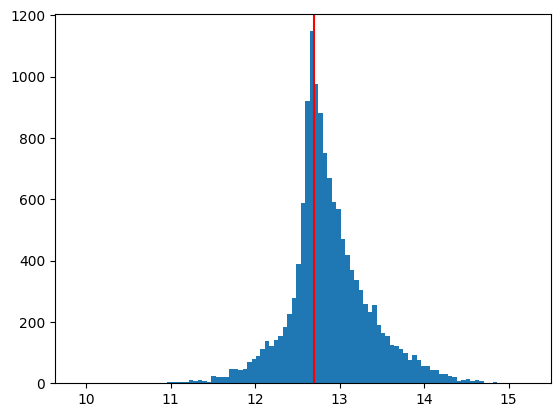

In [50]:
_, bins, _ = plt.hist(data['mvir'], bins=101); 
# plt.hist(data['m200'], bins=bins)
plt.axvline(12.7, c='r')

## Sanity check one MAH

In [10]:
# load pickle file
trees = _read_trees(trees_file)
cat = pd.read_hdf(present_snapfile)

/var/folders/yl/5w7yl6bn1tsc5fjrdtsrsjhh0000gn/T/ipykernel_2862/4011023914.py:3: RuntimeWarning: divide by zero encountered in log10
  return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)


In [11]:
# Lets pick a halo in the mass complete sample (mvir > 12.7 ~ Group_M_TopHat200)

# pick tress that have present day snap
trees1 = [t for t in trees if 99 in t['SnapNum']]

# now pick trees that have Group_M_TopHat200 > 12.8 (some margin)
gmass1 = np.array([t['Group_M_TopHat200'][-1] for t in trees1])
trees2 = [t for ii, t in enumerate(trees1) if gmass1[ii] > 12.8]
len(trees2), len(trees1)

(6567, 12522)

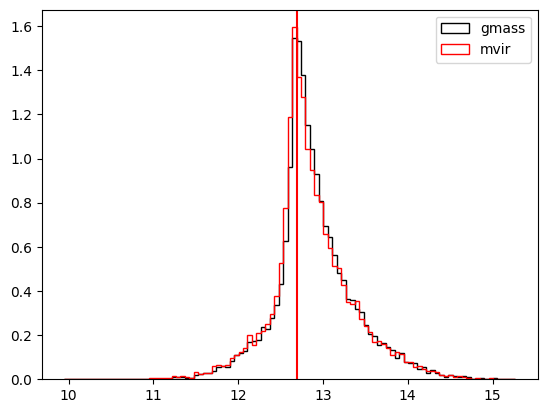

In [12]:
_, bins, _ = plt.hist(gmass1, bins=101, histtype='step', color='k', density=True, label='gmass');
_ = plt.hist(cat['Mvir'].values, bins=bins, histtype='step', color='r', density=True, label='mvir');
plt.axvline(12.7, c='r')
plt.legend()

In [13]:
# lets pick one of these trees
t_idx = 0
t = trees2[t_idx]
# t

In [14]:
t['Group_M_TopHat200'].shape

(99,)

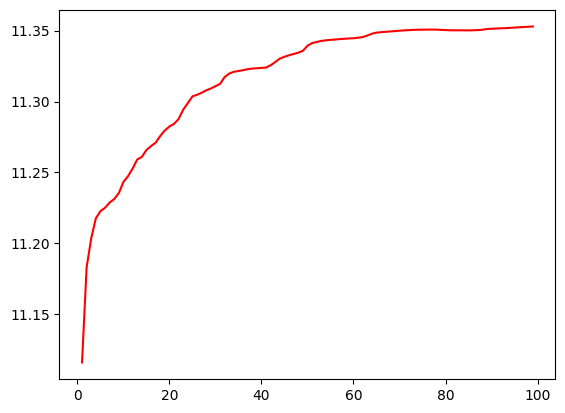

In [15]:
#let's plot gmass of this tree over time 
snaps_t = t['SnapNum']
gmass_t = _convert_tng_mass(t['Group_M_TopHat200'])
plt.plot(snaps_t, gmass_t, '-', c='r')

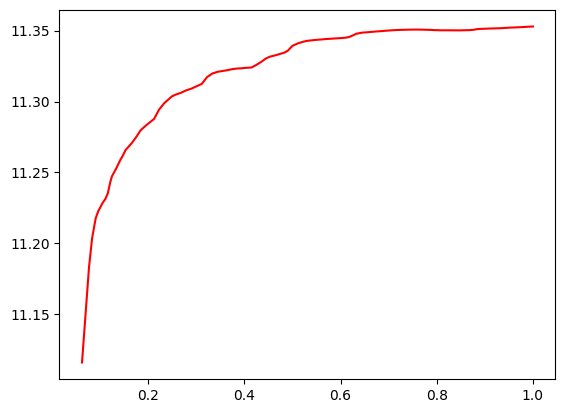

In [16]:
# now with redshift 
snaps_t = t['SnapNum']
gmass_t = _convert_tng_mass(t['Group_M_TopHat200'])
plt.plot(scales[snaps_t], gmass_t, '-', c='r')


## Sample selection and several MAHs

In [17]:
# pick trees half a decade after cut at 12.8
my_trees = [t for t in trees if 99 in t['SnapNum'] 
            and t['Group_M_TopHat200'][-1] > 12.8 
            and t['Group_M_TopHat200'][-1] < 13.3]
len(my_trees)

4510

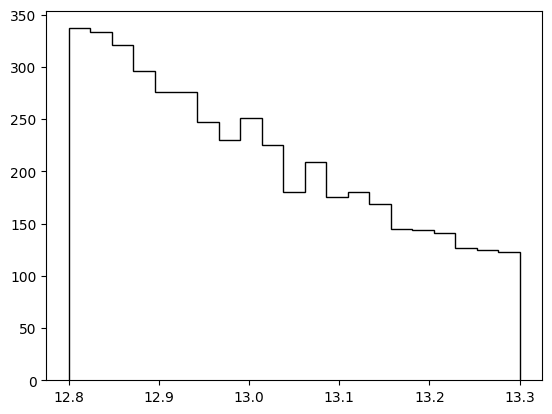

In [18]:
# double check
gmass = [t['Group_M_TopHat200'][-1] for t in my_trees]
plt.hist(gmass, bins=21, histtype='step', color='k', label='gmass');

In [19]:
# now we need to match with catalog
# let us check 1 halo
halo_idx = my_trees[0]['IndexInHaloTable'][-1]
mvir = cat["Mvir"].to_numpy()[halo_idx]
gmass = my_trees[0]['Group_M_TopHat200'][-1]
(gmass - mvir) / gmass * 100 , mvir, gmass 

(0.6185841597434866, 13.157593117913581, 13.2394905)

In [20]:
snaps.shape

(100,)

In [21]:
# get mah from trees, and convert to correct units
mah = np.zeros((len(my_trees), len(snaps)))
for ii, t in enumerate(my_trees):
    mah_t = np.zeros(len(snaps)) * np.nan
    t_snaps = t['SnapNum']
    gmass = t['Group_M_TopHat200']
    mah_t[t_snaps] = gmass

    # linearly interpolate nan values 
    mah_t = pd.Series(mah_t)
    mah_t = mah_t.interpolate(method='linear', limit_direction='forward', axis=0)
    mah[ii] = mah_t.values

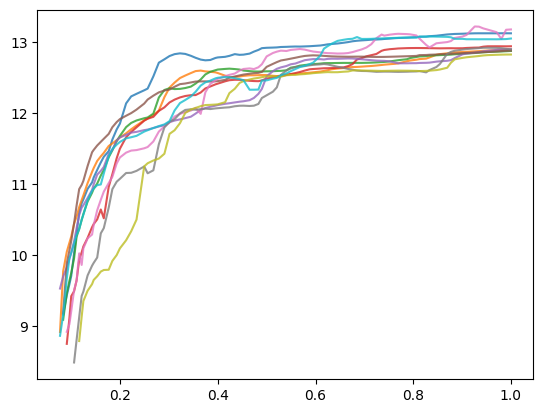

In [22]:
# plot 10 random mah as a function of scale 
for ii in range(10):
    idx = np.random.randint(0, len(my_trees))
    plt.plot(scales, mah[idx], '-', alpha=0.8
    );
# plt.plot(scales, mah.T, '-', alpha=0.1, c='k');

In [23]:
# let's make a cutoff at a = 0.185 like in our original paper
idx = np.where(scales > 0.185)[0][0]
_snaps = snaps[idx:]
_scales = scales[idx:]
_mah = mah[:, idx:]

In [24]:
_mah.shape, _scales.shape

((4510, 80), (80,))

In [25]:
# how many nan's remain? 
np.isnan(_mah).sum()

23

In [26]:
# remove haloes with nans and hope not too many
kp_idx = np.where(np.isnan(_mah).sum(axis=1) == 0)[0]
_mah = _mah[kp_idx]
assert np.isnan(_mah).sum() == 0 
_mah.shape # only 1 halo had nan's

(4509, 80)

In [ ]:
# turn mah in m_peak 
# which is the normalized cumulative maximum
Mpeak = np.fmax.accumulate(_mah, axis=1)
m_peak = Mpeak / Mpeak[:, -1][:, None]

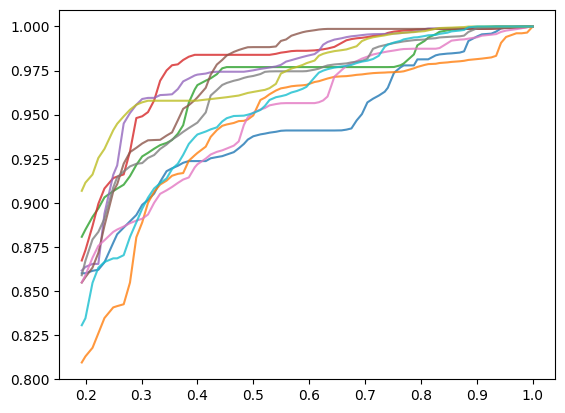

In [37]:
# plot 10 random m_peaks as a function of scale 
for ii in range(10):
    idx = np.random.randint(0, len(my_trees))
    plt.plot(_scales, m_peak[idx], '-', alpha=0.8
    );

## Create spearman correlation plots

In [27]:
# now all ids
halo_ids = np.array([t['IndexInHaloTable'][-1] for t in my_trees])[kp_idx]
halo_ids.shape

(4509,)

In [28]:
exclude = ["HaloID", "SubhaloID", "SubhaloID_DMO", 'SubhaloID_LastDesc', 'Central', 'Main', 'EndState']

In [29]:
# subset pandas dataframe to indices in halo_ids
_cat = cat.iloc[halo_ids]
len(_cat)

4509

In [36]:
# compute all spearman correlations for every quantity not in exclude
from multicam.correlations import spearmanr
corrs = {} 
for col in _cat.columns:
    if col not in exclude:
        corrs[col] = np.zeros(m_peak.shape[1]) * np.nan
        for jj in range(m_peak.shape[1]):
            corrs[col][jj] = spearmanr(_cat[col].values, m_peak[:, jj])


/Users/imendoza/Library/Caches/pypoetry/virtualenvs/multicam-P7T5KfjX-py3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [38]:
# now plot all correlations (separately), save to png
for col in _cat.columns:
    if col not in exclude:
        plt.figure(figsize=(5, 5))
        plt.plot(_scales, corrs[col], '-', c='k')
        plt.xlabel("a")
        plt.ylabel("Spearman r")
        plt.title(col)
        plt.savefig(f"../../results/tng/figs/{col}.png", bbox_inches='tight')
        plt.close()